All necessary libraries for working with data, machine learning and visualization are imported.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

Upload two CSV files: one contains information about bus stops, the other contains travel time data

In [ ]:
file_path_1 = "bus_stops_and_terminals_654.csv"
file_path_2 = "bus_running_times_654.csv"

df_stops = pd.read_csv(file_path_1)
df_times = pd.read_csv(file_path_2)

We combine two dataframes along the routes, select the features (`X`) and the target variable (`y`).

In [ ]:
merged_df = df_stops.merge(df_times, how='inner', left_on='route_id', right_on='trip_id')

X = merged_df[['latitude', 'longitude', 'length']]
y = merged_df['run_time_in_seconds']

We use `MinMaxScaler` to normalize the data, which improves the training of the neural network.

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

Convert `X_scaled` to 3D format for feeding into LSTM.

In [ ]:
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

We divide the data into training and test samples.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

We define and train an LSTM model to predict travel time.

In [ ]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

C:\Users\Айбек\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.1916 - val_loss: 0.1540
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0998 - val_loss: 0.0814
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0556 - val_loss: 0.0687
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0564 - val_loss: 0.0715
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0579 - val_loss: 0.0721
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0615 - val_loss: 0.0707
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0559 - val_loss: 0.0693
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0627 - val_loss: 0.0687
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0526 - val_loss: 0.0696
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0526 - val_loss: 0.0686
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0538 - val_loss: 0.0649
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

We obtain LSTM predictions that will be used in CatBoost.

In [ ]:
lstm_features = lstm_model.predict(X_train).flatten()
lstm_features_test = lstm_model.predict(X_test).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


We train `CatBoostRegressor` on LSTM predictions.

In [ ]:
catboost_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='MAE', verbose=100)
catboost_model.fit(lstm_features.reshape(-1, 1), scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten())

0:	learn: 77.5706042	total: 148ms	remaining: 1m 13s
100:	learn: 11.8605648	total: 267ms	remaining: 1.05s
200:	learn: 8.8695824	total: 387ms	remaining: 576ms
300:	learn: 7.7787719	total: 521ms	remaining: 345ms
400:	learn: 7.1843911	total: 650ms	remaining: 161ms
499:	learn: 6.4755504	total: 788ms	remaining: 0us


We calculate model quality metrics: MAE, RMSE and MAPE.

In [ ]:
y_pred = catboost_model.predict(lstm_features_test.reshape(-1, 1))

mae = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred)
rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred))
mape = np.mean(np.abs((scaler_y.inverse_transform(y_test.reshape(-1, 1)) - y_pred) / scaler_y.inverse_transform(y_test.reshape(-1, 1)))) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 10.0658
RMSE: 19.4377
MAPE: 107.04%


We build a training schedule for the LSTM model.

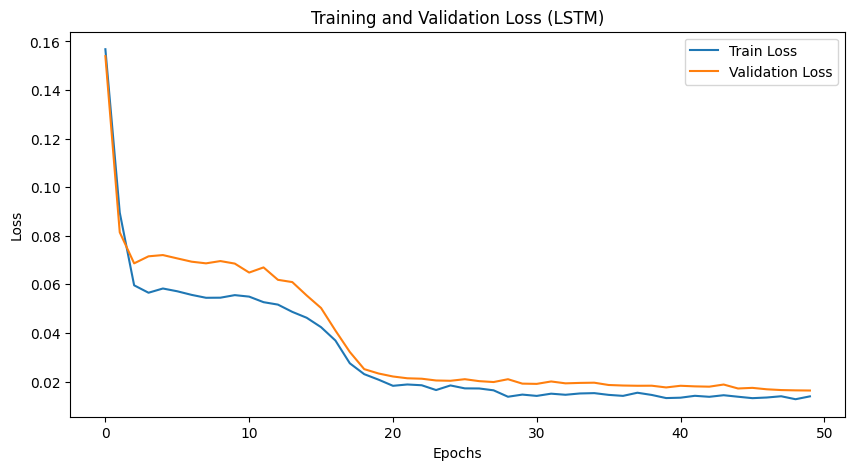

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.legend()
plt.show()

Create a scatterplot of predicted and actual values.

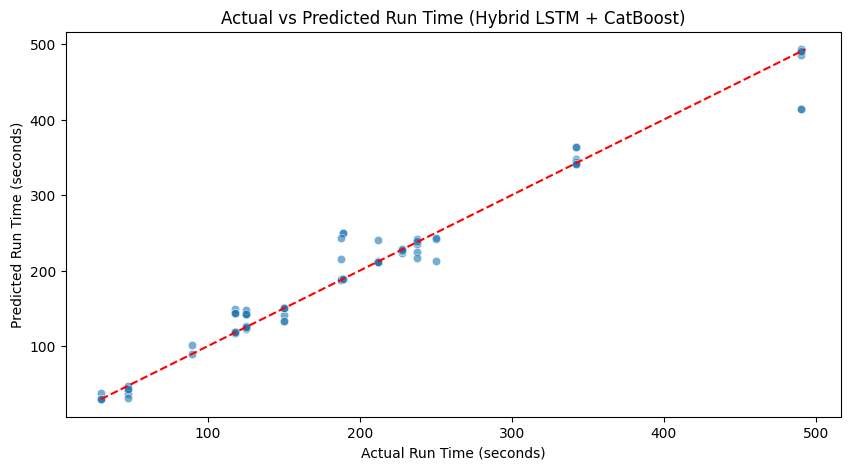

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(), y=y_pred, alpha=0.6)
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], '--r')
plt.xlabel("Actual Run Time (seconds)")
plt.ylabel("Predicted Run Time (seconds)")
plt.title("Actual vs Predicted Run Time (Hybrid LSTM + CatBoost)")
plt.show()

We build a graph of the importance of features in `CatBoost`.

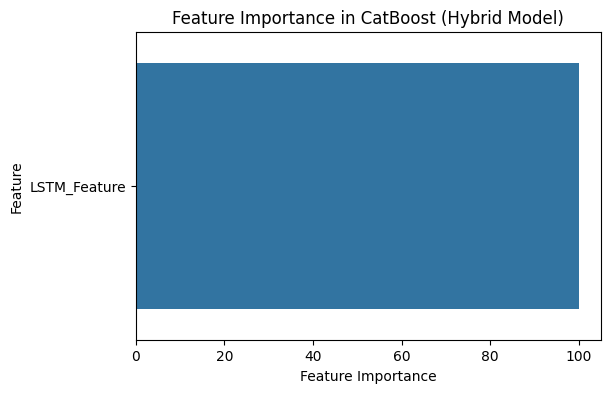

In [ ]:
feature_importances = catboost_model.get_feature_importance()
plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importances, y=['LSTM_Feature'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in CatBoost (Hybrid Model)")
plt.show()

We use `SHAP` to interpret the model.

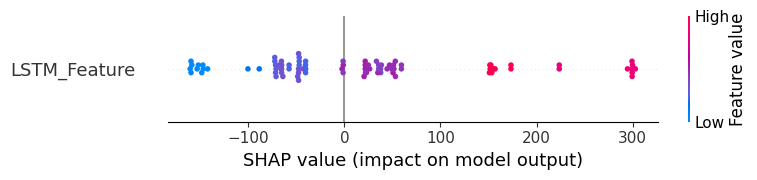

In [ ]:
explainer = shap.Explainer(catboost_model)
shap_values = explainer(lstm_features_test.reshape(-1, 1))

plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, lstm_features_test.reshape(-1, 1), feature_names=['LSTM_Feature'])